# 2020-11-30 • Sparse spike trains

Going further on {doc}`/notebooks/2020-11-30__speedup`, here we actually try to replace full "0/1" spike trains spike index arrays, in the entire codebase.

## Imports & time grid

In [1]:
from voltage_to_wiring_sim.support.notebook_init import *

Preloading:
 - numpy … (0.10 s)
 - matplotlib.pyplot … (0.22 s)
 - numba … (0.30 s)

Importing from submodules (compiling numba functions) … ✔

Imported `np`, `mpl`, `plt`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga`<br>on **Tue 29 Dec** 2020, at 21:23 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/a4689d4802b5f9cf6c930f077b6f9f83448e921b
) (Tue 29 Dec 2020, 21:19).

Uncommited changes to:
```
A  notebooks/2020-11-11__unitlib.ipynb
```

In [3]:
tg = v.TimeGrid(
    duration = 10 * minute,
    timestep = 0.1 * ms
);

## Generate VI signal

### Spike trains

In [4]:
N_in = 30
p_connected = 0.5

N_connected = round(N_in * p_connected)
N_unconnected = N_in - N_connected

15

In [5]:
f_spike = 20 * Hz;

In [6]:
gen_st = v.generate_Poisson_spikes

v.fix_rng_seed()

In [7]:
%%time
spike_trains_connected = [gen_st(f_spike, tg.duration) for _ in range(N_connected)]
spike_trains_unconnected = [gen_st(f_spike, tg.duration) for _ in range(N_unconnected)];

Wall time: 15 ms


This was 1.77 seconds when generating full 0/1 signals. I.e. we got 10x speedup by switching to drawing ISI's from an exponential and only saving spike times.

In [8]:
all_spike_trains = spike_trains_connected + spike_trains_unconnected;

In [9]:
time_slice = 1 * minute + np.array([0, 1]) * second

slice_indices = np.round(time_slice / tg.timestep).astype(int)
i_slice = slice(*slice_indices)
t_slice = tg.time[i_slice];

New eventplot function:

In [10]:
def plot_spike_train_excerpt(spike_train):
    return v.spike_trains.plot(spike_train, time_slice)

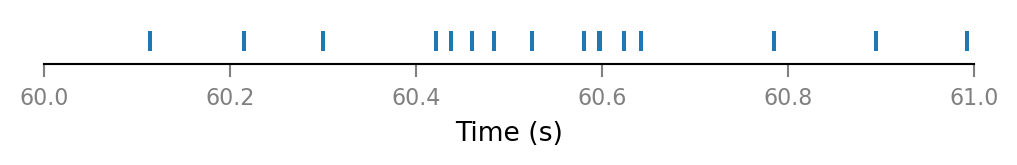

In [11]:
plot_spike_train_excerpt(all_spike_trains[0]);

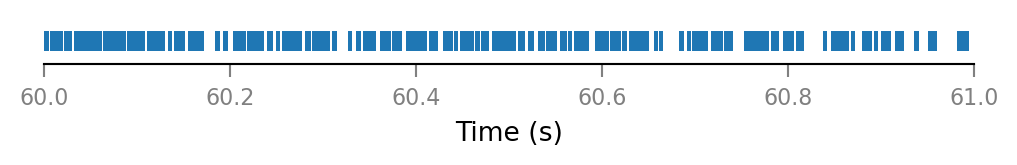

In [12]:
all_incoming_spikes = np.concatenate(spike_trains_connected)

plot_spike_train_excerpt(all_incoming_spikes);

### Synaptic conductance

In [13]:
Δg_syn = 0.8 * nS
τ_syn = 7 * ms;

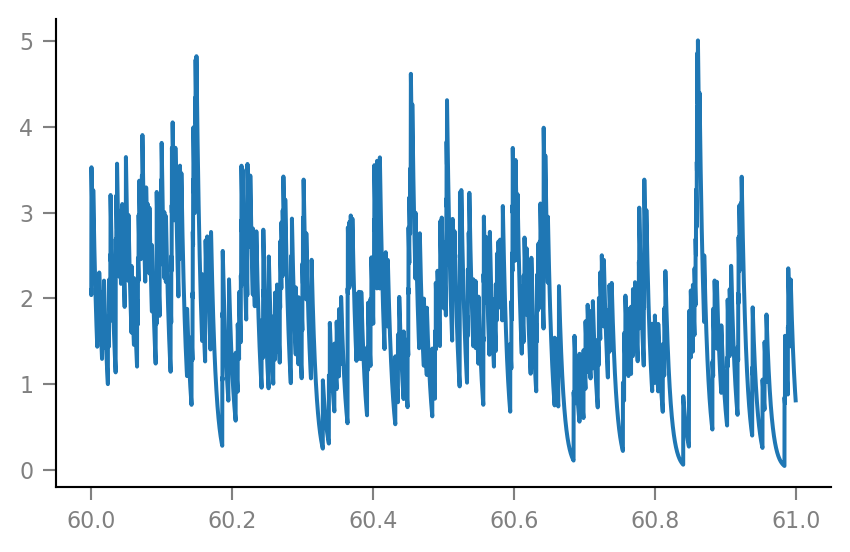

In [14]:
g_syn = v.calc_synaptic_conductance(tg, all_incoming_spikes, Δg_syn, τ_syn)

plt.plot(t_slice, g_syn[i_slice] / nS);

### Membrane voltage

In [15]:
params = v.params.cortical_RS
v.pprint(params)

IzhikevichParams
----------------
     C = 1E-10
     k = 7E-07
   v_r = -0.06
   v_t = -0.04
v_peak = 0.035
     a = 30
     b = -2E-09
     c = -0.05
     d = 1E-10
 v_syn = 0


In [16]:
%%time
sim = v.simulate_izh_neuron(tg, params, g_syn)

Wall time: 536 ms


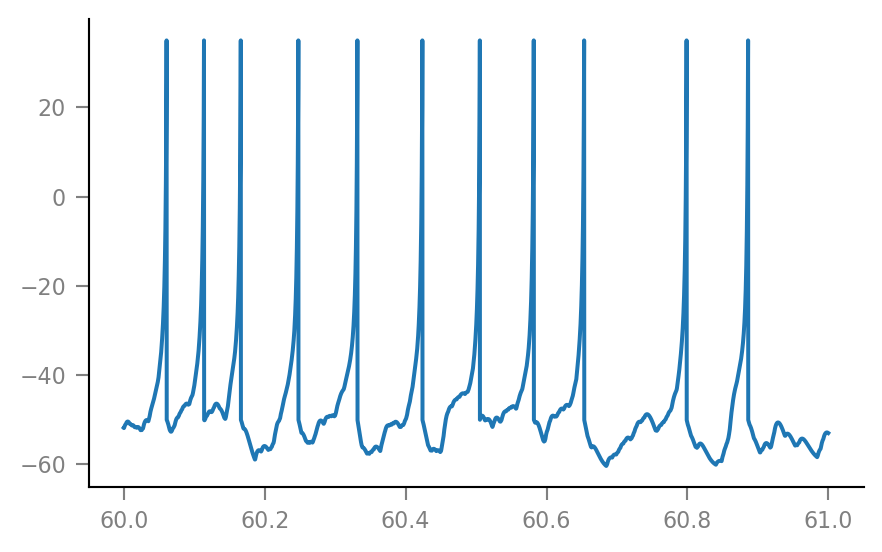

In [17]:
plt.plot(t_slice / second, sim.V_m[i_slice] / mV);

### Imaging model

In [18]:
Vm_noisy = v.add_VI_noise(sim.V_m, params)

plt.plot(t_slice / second, Vm_noisy[i_slice] / mV);

Signal(data=array([-0.02985, -0.05727, -0.07003, ..., -0.04183, -0.04099, -0.05304]), timestep=0.0001)

## Test connection
..of one spike train to imaged neuron.

In [19]:
spike_train = all_spike_trains[0];

In [20]:
%%prun -D temp.profile

v.fix_rng_seed()

test_data, test_summary = v.test_connection(
    spike_train,
    Vm_noisy,
    window_duration=100 * ms,
    num_shuffles=1000,
)

 
*** Profile stats marshalled to file 'temp.profile'. 


In [21]:
v.pprint(test_data)

ConnectionTestData
------------------
   shuffled_spike_trains = [array([0.0850..., 599.9, 600]), array([0.0097..., 599.8, 600]),
                            array([0.0090..., 599.9, 600]),
                            array([0.0466..., 599.9, 600]),
                            array([0.0309..., 599.9, 600]),
                            array([0.0360..., 599.9, 600]), ...]
     original_STA_height = 0.0003249
    shuffled_STA_heights = array([8.795E...5, 8.026E-05])
shuffled_STA_height_mean = 9.089E-05


In [22]:
test_data.original_STA_height / mV

0.3249126618965498

In [23]:
test_data.shuffled_STA_height_mean / mV

0.09089172066893161

(No easy way to make numpy numbers ("array scalars") print nicely, i.e. with less precision; besides casting to `float()`).

In [24]:
v.pprint(test_summary)

ConnectionTestSummary
---------------------
            p_value = 0.001
       p_value_type = '<'
relative_STA_height = 3.575


`v.test_connection` with 1000 shuffles took 5.2 à 5.3 seconds (with already done jit compilation).

Most time (4.2 s) was spent in `_calc_STA`, i.e. an already jit-compiled function.
(after that, 0.6 and 0.3 seconds were spent in `np.round` and `np.permutation`, respectively).

Can we speedup `_calc_STA` even more by parallelizing the loop? The loop iterations (cut out window and add to accumulator) are independent after all.

---
Wait. why is it suddenly 6.3 seconds for just 100 iterations above?\
-ah, maybe `parallel=False` is not the same as omitting `parallel` kwarg. Also there was the file based cache. Without those two, I get reproducible result: again 5.3 seconds for 1000 iterations, without `parallel`/`prange`.

---
Ok, now with `parallel`/`prange`:

In [25]:
%%prun -D temp.profile

v.fix_rng_seed()

test_data, test_summary = v.test_connection(
    spike_train,
    Vm_noisy,
    window_duration=100 * ms,
    num_shuffles=1000,
)

 
*** Profile stats marshalled to file 'temp.profile'. 


We get 3.4 seconds now. A definite improvement, but not massive.

1.77 seconds in `_calc_STA`, but suddenly 1.14 seconds in `np.round`, weirdly (`np.permutation` is still 0.23 s). [reproduced twice].

But looking just at `_calc_STA`, we do get a 2x improvement.

In [26]:
v.pprint(test_summary)

ConnectionTestSummary
---------------------
            p_value = 0.001
       p_value_type = '<'
relative_STA_height = 3.575


In [27]:
v.STA._calc_STA.jit_compiled_function.parallel_diagnostics()

 
 Parallel Accelerator Optimizing:  Function _calc_STA, c:\gdrive\phd\voltage-to-
wiring-sim\codebase\voltage_to_wiring_sim\STA.py (27)  


Parallel loop listing for  Function _calc_STA, c:\gdrive\phd\voltage-to-wiring-sim\codebase\voltage_to_wiring_sim\STA.py (27) 
-------------------------------------------------|loop #ID
@compile_to_machine_code(parallel=True)          | 
def _calc_STA(                                   | 
    VI_signal: np.ndarray,                       | 
    spike_indices: np.ndarray,                   | 
    window_length: int,                          | 
) -> np.ndarray:                                 | 
    num_windows = len(spike_indices)             | 
    STA = np.zeros(window_length)----------------| #0
    for i in prange(num_windows):----------------| #2
        start_ix = spike_indices[i]              | 
        end_ix = start_ix + window_length        | 
        if end_ix < len(VI_signal):              | 
            STA += VI_signal[start_ix:end_ix]

## Repro info

In [28]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `tfiers` on `yoga`<br>on **Tue 29 Dec** 2020, at 21:23 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/a4689d4802b5f9cf6c930f077b6f9f83448e921b
) (Tue 29 Dec 2020, 21:19).

Uncommited changes to:
```
A  notebooks/2020-11-11__unitlib.ipynb
?? notebooks/temp.profile
```

Platform:

Windows-10
CPython 3.8.3 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.19.2
matplotlib           3.3.2
numba                0.51.2
seaborn              0.10.1
scipy                1.5.2
scikit-learn         0.23.2
preload              2.1
py-cpuinfo           7.0.0
nptyping             1.3.0
